# Variational Autoencoder: LeNet-300-100 _full-connected_ with PyTorch and MNIST

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
import numpy as np

In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 80
batch_size = 256
learning_rate = 0.001

### MNIST data pre-processing:

#### Compute mean and standard deviation for different datasets

```
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

dataset_names = ('cifar10','cifar100','mnist')

parser = argparse.ArgumentParser(description='PyTorchLab')
parser.add_argument('-d', '--dataset', metavar='DATA', default='cifar10', choices=dataset_names,
                    help='dataset to be used: ' + ' | '.join(dataset_names) + ' (default: cifar10)')

args = parser.parse_args()

data_dir = os.path.join('.', args.dataset)

print(args.dataset)

if args.dataset == "cifar10":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(train_set.train_data.mean(axis=(0,1,2))/255)
    print(train_set.train_data.std(axis=(0,1,2))/255)

elif args.dataset == "cifar100":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(np.mean(train_set.train_data, axis=(0,1,2))/255)
    print(np.std(train_set.train_data, axis=(0,1,2))/255)

elif args.dataset == "mnist":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(list(train_set.train_data.size()))
    print(train_set.train_data.float().mean()/255)
    print(train_set.train_data.float().std()/255)
```

[Reference](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [8]:
path_to_data = "C:\\Users\\arjun\Downloads\\"

In [9]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )

In [10]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [11]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [12]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [13]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")

mean = 0.1307


In [14]:
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

std dev = 0.3081


#### NOTE:

Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [15]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [16]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Scale pixel values in the range 0 to 1

To manually convert the pixel values in the range 0 to 1, divide the training and testing datasets by 255.0.

In [17]:
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [18]:
type(train), type(test)

(torch.Tensor, torch.Tensor)

In [19]:
train.shape, test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [20]:
# Reshape to include gray-scale channel-
# train = train.reshape(60000, 1, 28, 28)
# test = test.reshape(10000, 1, 28, 28)

# Reshape the datasets into a flattened shape for LeNet300
# architecture-
train = train.view(-1, 28 * 28 * 1)
test = test.view(-1, 28 * 28 * 1)

In [21]:
# Sanity check-
train.shape, test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [22]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [23]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [24]:
del train_dataset, test_dataset

In [25]:
print(f"batch size to be used = {batch_size}")

batch size to be used = 256


In [26]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test, batch_size = batch_size,
        shuffle = False
        )

In [27]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 235 and test_loader: 40


In [28]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [29]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(234.375, 39.0625)

In [30]:
# Get some random batch of training images & labels-
# images, labels = next(iter(train_loader))
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([256, 784])


In [31]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [32]:
# De-normalize the batch of images-
images *= 255.0

In [33]:
images.min(), images.max()

(tensor(0.), tensor(255.))

In [34]:
# Reshape images for visualization-
images = images.view(-1, 1, 28, 28)

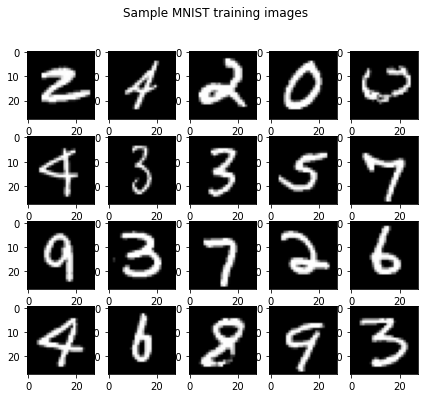

In [36]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [35]:
del images

### Define Variational Autoencoder architecture using _dense_ layers

In [36]:
class LeNet300_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet300_Encoder, self).__init__()
        self.latent_space = latent_space
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = 28 * 28 * 1, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.encoder_output = nn.Linear(in_features = 100, out_features = self.latent_space)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.encoder_output(x))
        return x
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"encoder output shape: {x.shape}")
        del x
        return None
    
    

In [37]:
class LeNet300_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet300_Decoder, self).__init__()
        self.latent_space = latent_space
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = self.latent_space, out_features = 50)
        self.fc2 = nn.Linear(in_features = 50, out_features = 100)
        self.fc3 = nn.Linear(in_features = 100, out_features = 300)
        self.decoder_output = nn.Linear(in_features = 300, out_features = 28 * 28 * 1)
    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.decoder_output(x)
        return x
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # nn.init.kaiming_normal_(m.weight)
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.fc3(x)
        print(f"dense3 output shape: {x.shape}")
        x = self.decoder_output(x)
        print(f"decoder output shape: {x.shape}")
        del x
        return None
    

In [38]:
class VAE_Dense(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Dense, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet300_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'mu' & 'log_var' vectors to convert the bottleneck into
        # μ and σ vectors-
        self.mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet300_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        
        The log-var trick allows us to have both positive and negative values instead
        of only having positive values if standard deviation was used. Having both
        positive & negative values is good for the neural network training process.
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' is sampled from a standard normal distribution
        # to add stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        # Encode input data using encoder-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        # Decode latent vector using decoder-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        del x, mu, log_var, z
        return None
    
    

In [39]:
# Initialize a VAE object-
model = VAE_Dense(latent_space = 3).to(device)

In [42]:
print(model)

VAE_Dense(
  (encoder): LeNet300_Encoder(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
    (encoder_output): Linear(in_features=100, out_features=3, bias=True)
  )
  (mu): Linear(in_features=3, out_features=3, bias=True)
  (log_var): Linear(in_features=3, out_features=3, bias=True)
  (decoder): LeNet300_Decoder(
    (fc1): Linear(in_features=3, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=300, bias=True)
    (decoder_output): Linear(in_features=300, out_features=784, bias=True)
  )
)


In [43]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([300, 784]) has 235200 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([100, 300]) has 30000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([3, 100]) has 300 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([50, 3]) has 150 parameters
layer.shape = torch.Size([50]) has 50 parameters
layer.shape = torch.Size([100, 50]) has 5000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([300, 100]) has 30000 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([784, 300]) has 235200 parameters
layer.shape = torch.Size([784]) has 784 parameters


In [44]:
print(f"Total number of parameters in VAE Conv model = {tot_params}")

Total number of parameters in VAE Conv model = 537511


In [56]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Random_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load(VAE_LeNet300_MNIST_Random_Weights.pth', map_location = torch.device('cpu')))

### Initial variance - Sanity check:

Before training the VAE neural network model, there should be some initial variance.

In [45]:
for x in model.mu.parameters():
    print(x.shape, x.nelement())

torch.Size([3, 3]) 9
torch.Size([3]) 3


In [46]:
log_var_wts = model.log_var.weight
mu_wts = model.mu.weight

In [47]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [48]:
mu_wts.shape, log_var_wts.shape

((3, 3), (3, 3))

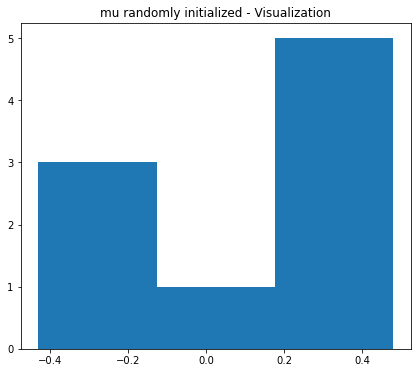

In [50]:
plt.figure(figsize = (7, 6))
# sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
n, bins, patches = plt.hist(mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

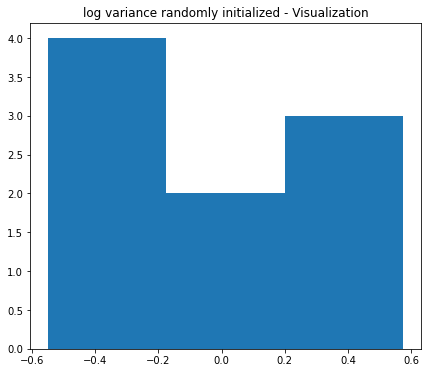

In [51]:
plt.figure(figsize = (7, 6))
# sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
n, bins, patches = plt.hist(log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [52]:
del mu_wts, log_var_wts

In [54]:
# Sanity check-
images = next(iter(train_loader))
images = images.to(device)

In [55]:
images.shape

torch.Size([256, 784])

In [56]:
images.min(), images.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [57]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [58]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([256, 784]), torch.Size([256, 3]), torch.Size([256, 3]))

In [59]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0.37977085, dtype=float32), array(0.5937908, dtype=float32))

In [60]:
del images, recon_images, mu, log_var

In [40]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [41]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [42]:
def total_loss(data, data_recon, mu, log_var, alpha = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Compute KL-Divergence loss:
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    
    # kl_div.shape
    # torch.Size([64])
    
    batchsize = kl_div.size(0)

    # Compute average KL-divergence over batch size-
    kl_div = kl_div.mean()
    
    
    # Compute Reconstruction loss:
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    # Reshape recon_loss so that it is the batchsize and a vector. So, instead
    # of having a tensor, it is now a matrix (table). Then, sum over the pixels.
    # This is equivalent to summing over the latent dimensions for kl_div above.
    # We are summing first the squared error over the pixels and then average over
    # the batch dimensions below-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([64, 784])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + kl_div
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
# Sanity check-
final_loss, recon_loss, kl_div_loss = total_loss(
    data = images, data_recon = recon_images,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"final loss = {final_loss.cpu().detach().numpy():.4f},"
      f" reconstruction loss = {recon_loss.cpu().detach().numpy():.4f}"
      f" & kl-div loss = {kl_div_loss.cpu().detach().numpy():.4f}"
     )
'''

In [43]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        # total = int(len(train_dataset) / dataloader.batch_size)
        total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = total_loss(
            data = data, data_recon = recon_data,
            mu = mu, log_var = logvar,
            alpha = alpha
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [44]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            # total = int(len(test_dataset) / dataloader.batch_size)):
            total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = data, data_recon = recon_data,
                mu = mu, log_var = logvar,
                alpha = alpha
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss

    

In [ ]:
'''
# Sanity check-
train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = 1
)
'''

In [ ]:
'''
val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = 1
)
'''

In [ ]:
'''
print(f"After one epoch: train loss = {train_loss:.4f}, recon loss = {recon_train_loss:.4f}"
      f" & kl-div loss = {kl_train_loss:.4f}"
     )
'''

In [ ]:
'''
print(f"After one epoch: val train loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f}"
      f" & val kl-div loss = {val_kl_loss:.4f}"
     )
'''

### Train VAE model 

In [76]:
# Initialize a VAE objetc-
model = VAE_Dense(latent_space = 3).to(device)

In [77]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Random_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load(VAE_LeNet300_MNIST_Random_Weights.pth', map_location = torch.device('cpu')))

In [45]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [46]:
# Python dict to contain training metrics-
train_history = {}

In [47]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 80 epochs


In [48]:
# Initialize parameter for saving 'best' parameters-
best_val_loss = 10000

In [49]:
for epoch in range(1, num_epochs + 1):
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (val_loss < best_val_loss):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet300_MNIST_best_model.pth")
        
    

235it [00:03, 74.80it/s]                                                                                               
40it [00:00, 571.30it/s]                                                                                               


Epoch = 1; train loss = 0.2245 , kl-loss = 0.0048, recon loss = 0.2197 , val loss = 0.1991, val kl-loss = 0.0053  & val recon loss = 0.1938
Saving model with lowest val_loss = 0.1991



235it [00:01, 218.35it/s]                                                                                              
40it [00:00, 588.11it/s]                                                                                               


Epoch = 2; train loss = 0.1918 , kl-loss = 0.0061, recon loss = 0.1857 , val loss = 0.1943, val kl-loss = 0.0065  & val recon loss = 0.1878
Saving model with lowest val_loss = 0.1943



235it [00:01, 219.06it/s]                                                                                              
40it [00:00, 506.21it/s]                                                                                               


Epoch = 3; train loss = 0.1861 , kl-loss = 0.0083, recon loss = 0.1778 , val loss = 0.1871, val kl-loss = 0.0100  & val recon loss = 0.1771
Saving model with lowest val_loss = 0.1871



235it [00:01, 218.96it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 4; train loss = 0.1805 , kl-loss = 0.0106, recon loss = 0.1700 , val loss = 0.1828, val kl-loss = 0.0117  & val recon loss = 0.1711
Saving model with lowest val_loss = 0.1828



235it [00:01, 209.82it/s]                                                                                              
40it [00:00, 540.42it/s]                                                                                               


Epoch = 5; train loss = 0.1747 , kl-loss = 0.0118, recon loss = 0.1630 , val loss = 0.1759, val kl-loss = 0.0123  & val recon loss = 0.1636
Saving model with lowest val_loss = 0.1759



235it [00:01, 218.35it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 6; train loss = 0.1706 , kl-loss = 0.0125, recon loss = 0.1581 , val loss = 0.1729, val kl-loss = 0.0133  & val recon loss = 0.1595
Saving model with lowest val_loss = 0.1729



235it [00:01, 221.23it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 7; train loss = 0.1672 , kl-loss = 0.0138, recon loss = 0.1534 , val loss = 0.1694, val kl-loss = 0.0151  & val recon loss = 0.1543
Saving model with lowest val_loss = 0.1694



235it [00:01, 218.35it/s]                                                                                              
40it [00:00, 555.42it/s]                                                                                               


Epoch = 8; train loss = 0.1640 , kl-loss = 0.0150, recon loss = 0.1489 , val loss = 0.1664, val kl-loss = 0.0159  & val recon loss = 0.1505
Saving model with lowest val_loss = 0.1664



235it [00:01, 221.88it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 9; train loss = 0.1610 , kl-loss = 0.0160, recon loss = 0.1451 , val loss = 0.1628, val kl-loss = 0.0169  & val recon loss = 0.1459
Saving model with lowest val_loss = 0.1628



235it [00:01, 219.02it/s]                                                                                              
40it [00:00, 645.02it/s]                                                                                               


Epoch = 10; train loss = 0.1585 , kl-loss = 0.0168, recon loss = 0.1417 , val loss = 0.1599, val kl-loss = 0.0178  & val recon loss = 0.1422
Saving model with lowest val_loss = 0.1599



235it [00:01, 219.88it/s]                                                                                              
40it [00:00, 571.30it/s]                                                                                               


Epoch = 11; train loss = 0.1559 , kl-loss = 0.0177, recon loss = 0.1383 , val loss = 0.1578, val kl-loss = 0.0184  & val recon loss = 0.1394
Saving model with lowest val_loss = 0.1578



235it [00:01, 215.75it/s]                                                                                              
40it [00:00, 555.43it/s]                                                                                               


Epoch = 12; train loss = 0.1541 , kl-loss = 0.0181, recon loss = 0.1360 , val loss = 0.1570, val kl-loss = 0.0188  & val recon loss = 0.1382
Saving model with lowest val_loss = 0.1570



235it [00:01, 218.35it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 13; train loss = 0.1526 , kl-loss = 0.0185, recon loss = 0.1340 , val loss = 0.1551, val kl-loss = 0.0192  & val recon loss = 0.1359
Saving model with lowest val_loss = 0.1551



235it [00:01, 218.55it/s]                                                                                              
40it [00:00, 571.30it/s]                                                                                               


Epoch = 14; train loss = 0.1511 , kl-loss = 0.0188, recon loss = 0.1323 , val loss = 0.1538, val kl-loss = 0.0189  & val recon loss = 0.1350
Saving model with lowest val_loss = 0.1538



235it [00:01, 219.79it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 15; train loss = 0.1496 , kl-loss = 0.0192, recon loss = 0.1305 , val loss = 0.1519, val kl-loss = 0.0196  & val recon loss = 0.1323
Saving model with lowest val_loss = 0.1519



235it [00:01, 218.30it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 16; train loss = 0.1484 , kl-loss = 0.0194, recon loss = 0.1290 , val loss = 0.1514, val kl-loss = 0.0201  & val recon loss = 0.1313
Saving model with lowest val_loss = 0.1514



235it [00:01, 221.17it/s]                                                                                              
40it [00:00, 547.82it/s]                                                                                               


Epoch = 17; train loss = 0.1473 , kl-loss = 0.0196, recon loss = 0.1276 , val loss = 0.1505, val kl-loss = 0.0199  & val recon loss = 0.1306
Saving model with lowest val_loss = 0.1505



235it [00:01, 220.40it/s]                                                                                              
40it [00:00, 540.42it/s]                                                                                               


Epoch = 18; train loss = 0.1462 , kl-loss = 0.0198, recon loss = 0.1265 , val loss = 0.1493, val kl-loss = 0.0200  & val recon loss = 0.1293
Saving model with lowest val_loss = 0.1493



235it [00:01, 218.35it/s]                                                                                              
40it [00:00, 571.30it/s]                                                                                               


Epoch = 19; train loss = 0.1452 , kl-loss = 0.0199, recon loss = 0.1254 , val loss = 0.1486, val kl-loss = 0.0203  & val recon loss = 0.1283
Saving model with lowest val_loss = 0.1486



235it [00:01, 219.37it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 20; train loss = 0.1445 , kl-loss = 0.0200, recon loss = 0.1245 , val loss = 0.1479, val kl-loss = 0.0205  & val recon loss = 0.1273
Saving model with lowest val_loss = 0.1479



235it [00:01, 217.34it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 21; train loss = 0.1437 , kl-loss = 0.0200, recon loss = 0.1237 , val loss = 0.1478, val kl-loss = 0.0208  & val recon loss = 0.1270
Saving model with lowest val_loss = 0.1478



235it [00:01, 218.76it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 22; train loss = 0.1432 , kl-loss = 0.0201, recon loss = 0.1231 , val loss = 0.1472, val kl-loss = 0.0206  & val recon loss = 0.1266
Saving model with lowest val_loss = 0.1472



235it [00:01, 206.82it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 23; train loss = 0.1426 , kl-loss = 0.0202, recon loss = 0.1224 , val loss = 0.1464, val kl-loss = 0.0206  & val recon loss = 0.1258
Saving model with lowest val_loss = 0.1464



235it [00:01, 220.40it/s]                                                                                              
40it [00:00, 615.24it/s]                                                                                               


Epoch = 24; train loss = 0.1422 , kl-loss = 0.0204, recon loss = 0.1218 , val loss = 0.1466, val kl-loss = 0.0204  & val recon loss = 0.1262


235it [00:01, 213.98it/s]                                                                                              
40it [00:00, 563.25it/s]                                                                                               


Epoch = 25; train loss = 0.1414 , kl-loss = 0.0204, recon loss = 0.1210 , val loss = 0.1454, val kl-loss = 0.0209  & val recon loss = 0.1244
Saving model with lowest val_loss = 0.1454



235it [00:01, 223.76it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 26; train loss = 0.1410 , kl-loss = 0.0205, recon loss = 0.1205 , val loss = 0.1446, val kl-loss = 0.0208  & val recon loss = 0.1238
Saving model with lowest val_loss = 0.1446



235it [00:01, 222.91it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 27; train loss = 0.1407 , kl-loss = 0.0207, recon loss = 0.1200 , val loss = 0.1442, val kl-loss = 0.0212  & val recon loss = 0.1230
Saving model with lowest val_loss = 0.1442



235it [00:01, 224.19it/s]                                                                                              
40it [00:00, 634.78it/s]                                                                                               


Epoch = 28; train loss = 0.1402 , kl-loss = 0.0208, recon loss = 0.1195 , val loss = 0.1450, val kl-loss = 0.0209  & val recon loss = 0.1241


235it [00:01, 222.28it/s]                                                                                              
40it [00:00, 634.77it/s]                                                                                               


Epoch = 29; train loss = 0.1397 , kl-loss = 0.0209, recon loss = 0.1189 , val loss = 0.1436, val kl-loss = 0.0210  & val recon loss = 0.1225
Saving model with lowest val_loss = 0.1436



235it [00:01, 221.23it/s]                                                                                              
40it [00:00, 555.43it/s]                                                                                               


Epoch = 30; train loss = 0.1394 , kl-loss = 0.0210, recon loss = 0.1185 , val loss = 0.1438, val kl-loss = 0.0216  & val recon loss = 0.1222


235it [00:01, 222.70it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 31; train loss = 0.1389 , kl-loss = 0.0211, recon loss = 0.1178 , val loss = 0.1433, val kl-loss = 0.0213  & val recon loss = 0.1220
Saving model with lowest val_loss = 0.1433



235it [00:01, 221.23it/s]                                                                                              
40it [00:00, 645.01it/s]                                                                                               


Epoch = 32; train loss = 0.1386 , kl-loss = 0.0212, recon loss = 0.1174 , val loss = 0.1439, val kl-loss = 0.0215  & val recon loss = 0.1225


235it [00:01, 222.91it/s]                                                                                              
40it [00:00, 563.26it/s]                                                                                               


Epoch = 33; train loss = 0.1383 , kl-loss = 0.0213, recon loss = 0.1170 , val loss = 0.1425, val kl-loss = 0.0215  & val recon loss = 0.1210
Saving model with lowest val_loss = 0.1425



235it [00:01, 222.70it/s]                                                                                              
40it [00:00, 645.02it/s]                                                                                               


Epoch = 34; train loss = 0.1378 , kl-loss = 0.0214, recon loss = 0.1164 , val loss = 0.1427, val kl-loss = 0.0218  & val recon loss = 0.1209


235it [00:01, 221.65it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 35; train loss = 0.1374 , kl-loss = 0.0215, recon loss = 0.1160 , val loss = 0.1420, val kl-loss = 0.0220  & val recon loss = 0.1200
Saving model with lowest val_loss = 0.1420



235it [00:01, 222.70it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 36; train loss = 0.1371 , kl-loss = 0.0216, recon loss = 0.1156 , val loss = 0.1422, val kl-loss = 0.0216  & val recon loss = 0.1206


235it [00:01, 222.70it/s]                                                                                              
40it [00:00, 615.24it/s]                                                                                               


Epoch = 37; train loss = 0.1369 , kl-loss = 0.0216, recon loss = 0.1153 , val loss = 0.1416, val kl-loss = 0.0222  & val recon loss = 0.1194
Saving model with lowest val_loss = 0.1416



235it [00:01, 222.49it/s]                                                                                              
40it [00:00, 588.11it/s]                                                                                               


Epoch = 38; train loss = 0.1368 , kl-loss = 0.0217, recon loss = 0.1151 , val loss = 0.1421, val kl-loss = 0.0221  & val recon loss = 0.1199


235it [00:01, 222.91it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 39; train loss = 0.1364 , kl-loss = 0.0218, recon loss = 0.1146 , val loss = 0.1417, val kl-loss = 0.0222  & val recon loss = 0.1195


235it [00:01, 221.86it/s]                                                                                              
40it [00:00, 615.24it/s]                                                                                               


Epoch = 40; train loss = 0.1361 , kl-loss = 0.0218, recon loss = 0.1143 , val loss = 0.1413, val kl-loss = 0.0219  & val recon loss = 0.1194
Saving model with lowest val_loss = 0.1413



235it [00:01, 221.23it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 41; train loss = 0.1358 , kl-loss = 0.0219, recon loss = 0.1139 , val loss = 0.1412, val kl-loss = 0.0224  & val recon loss = 0.1188
Saving model with lowest val_loss = 0.1412



235it [00:01, 221.86it/s]                                                                                              
40it [00:00, 634.78it/s]                                                                                               


Epoch = 42; train loss = 0.1355 , kl-loss = 0.0219, recon loss = 0.1136 , val loss = 0.1411, val kl-loss = 0.0221  & val recon loss = 0.1190
Saving model with lowest val_loss = 0.1411



235it [00:01, 222.28it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 43; train loss = 0.1355 , kl-loss = 0.0220, recon loss = 0.1135 , val loss = 0.1401, val kl-loss = 0.0223  & val recon loss = 0.1178
Saving model with lowest val_loss = 0.1401



235it [00:01, 222.49it/s]                                                                                              
40it [00:00, 571.30it/s]                                                                                               


Epoch = 44; train loss = 0.1354 , kl-loss = 0.0221, recon loss = 0.1133 , val loss = 0.1412, val kl-loss = 0.0224  & val recon loss = 0.1187


235it [00:01, 221.23it/s]                                                                                              
40it [00:00, 588.11it/s]                                                                                               


Epoch = 45; train loss = 0.1352 , kl-loss = 0.0221, recon loss = 0.1130 , val loss = 0.1399, val kl-loss = 0.0224  & val recon loss = 0.1175
Saving model with lowest val_loss = 0.1399



235it [00:01, 222.70it/s]                                                                                              
40it [00:00, 624.85it/s]                                                                                               


Epoch = 46; train loss = 0.1350 , kl-loss = 0.0222, recon loss = 0.1128 , val loss = 0.1400, val kl-loss = 0.0225  & val recon loss = 0.1175


235it [00:01, 221.44it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 47; train loss = 0.1350 , kl-loss = 0.0222, recon loss = 0.1127 , val loss = 0.1403, val kl-loss = 0.0228  & val recon loss = 0.1175


235it [00:01, 221.86it/s]                                                                                              
40it [00:00, 615.24it/s]                                                                                               


Epoch = 48; train loss = 0.1345 , kl-loss = 0.0223, recon loss = 0.1122 , val loss = 0.1407, val kl-loss = 0.0229  & val recon loss = 0.1179


235it [00:01, 222.07it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 49; train loss = 0.1344 , kl-loss = 0.0223, recon loss = 0.1120 , val loss = 0.1398, val kl-loss = 0.0226  & val recon loss = 0.1171
Saving model with lowest val_loss = 0.1398



235it [00:01, 205.19it/s]                                                                                              
40it [00:00, 588.11it/s]                                                                                               


Epoch = 50; train loss = 0.1341 , kl-loss = 0.0224, recon loss = 0.1117 , val loss = 0.1400, val kl-loss = 0.0226  & val recon loss = 0.1174


235it [00:01, 217.47it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 51; train loss = 0.1339 , kl-loss = 0.0224, recon loss = 0.1115 , val loss = 0.1401, val kl-loss = 0.0227  & val recon loss = 0.1174


235it [00:01, 218.02it/s]                                                                                              
40it [00:00, 655.59it/s]                                                                                               


Epoch = 52; train loss = 0.1339 , kl-loss = 0.0225, recon loss = 0.1114 , val loss = 0.1400, val kl-loss = 0.0227  & val recon loss = 0.1173


235it [00:01, 215.94it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 53; train loss = 0.1338 , kl-loss = 0.0225, recon loss = 0.1113 , val loss = 0.1393, val kl-loss = 0.0228  & val recon loss = 0.1164
Saving model with lowest val_loss = 0.1393



235it [00:01, 217.34it/s]                                                                                              
40it [00:00, 634.77it/s]                                                                                               


Epoch = 54; train loss = 0.1338 , kl-loss = 0.0226, recon loss = 0.1112 , val loss = 0.1397, val kl-loss = 0.0229  & val recon loss = 0.1169


235it [00:01, 217.54it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 55; train loss = 0.1335 , kl-loss = 0.0226, recon loss = 0.1109 , val loss = 0.1390, val kl-loss = 0.0232  & val recon loss = 0.1158
Saving model with lowest val_loss = 0.1390



235it [00:01, 219.58it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 56; train loss = 0.1333 , kl-loss = 0.0229, recon loss = 0.1104 , val loss = 0.1395, val kl-loss = 0.0235  & val recon loss = 0.1161


235it [00:01, 217.34it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 57; train loss = 0.1326 , kl-loss = 0.0235, recon loss = 0.1092 , val loss = 0.1381, val kl-loss = 0.0241  & val recon loss = 0.1140
Saving model with lowest val_loss = 0.1381



235it [00:01, 216.14it/s]                                                                                              
40it [00:00, 563.26it/s]                                                                                               


Epoch = 58; train loss = 0.1317 , kl-loss = 0.0239, recon loss = 0.1077 , val loss = 0.1370, val kl-loss = 0.0242  & val recon loss = 0.1128
Saving model with lowest val_loss = 0.1370



235it [00:01, 217.75it/s]                                                                                              
40it [00:00, 634.78it/s]                                                                                               


Epoch = 59; train loss = 0.1310 , kl-loss = 0.0240, recon loss = 0.1070 , val loss = 0.1367, val kl-loss = 0.0243  & val recon loss = 0.1124
Saving model with lowest val_loss = 0.1367



235it [00:01, 218.15it/s]                                                                                              
40it [00:00, 655.59it/s]                                                                                               


Epoch = 60; train loss = 0.1309 , kl-loss = 0.0242, recon loss = 0.1067 , val loss = 0.1364, val kl-loss = 0.0244  & val recon loss = 0.1119
Saving model with lowest val_loss = 0.1364



235it [00:01, 218.96it/s]                                                                                              
40it [00:00, 634.78it/s]                                                                                               


Epoch = 61; train loss = 0.1305 , kl-loss = 0.0242, recon loss = 0.1062 , val loss = 0.1363, val kl-loss = 0.0246  & val recon loss = 0.1117
Saving model with lowest val_loss = 0.1363



235it [00:01, 216.94it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 62; train loss = 0.1302 , kl-loss = 0.0244, recon loss = 0.1058 , val loss = 0.1358, val kl-loss = 0.0247  & val recon loss = 0.1111
Saving model with lowest val_loss = 0.1358



235it [00:01, 216.74it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 63; train loss = 0.1300 , kl-loss = 0.0245, recon loss = 0.1055 , val loss = 0.1357, val kl-loss = 0.0248  & val recon loss = 0.1109
Saving model with lowest val_loss = 0.1357



235it [00:01, 216.14it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 64; train loss = 0.1300 , kl-loss = 0.0245, recon loss = 0.1055 , val loss = 0.1362, val kl-loss = 0.0249  & val recon loss = 0.1113


235it [00:01, 216.74it/s]                                                                                              
40it [00:00, 596.89it/s]                                                                                               


Epoch = 65; train loss = 0.1298 , kl-loss = 0.0246, recon loss = 0.1052 , val loss = 0.1361, val kl-loss = 0.0249  & val recon loss = 0.1112


235it [00:01, 216.14it/s]                                                                                              
40it [00:00, 605.92it/s]                                                                                               


Epoch = 66; train loss = 0.1296 , kl-loss = 0.0246, recon loss = 0.1051 , val loss = 0.1355, val kl-loss = 0.0248  & val recon loss = 0.1107
Saving model with lowest val_loss = 0.1355



235it [00:01, 216.94it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 67; train loss = 0.1293 , kl-loss = 0.0248, recon loss = 0.1045 , val loss = 0.1353, val kl-loss = 0.0250  & val recon loss = 0.1103
Saving model with lowest val_loss = 0.1353



235it [00:01, 217.95it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 68; train loss = 0.1291 , kl-loss = 0.0248, recon loss = 0.1043 , val loss = 0.1353, val kl-loss = 0.0250  & val recon loss = 0.1103


235it [00:01, 217.64it/s]                                                                                              
40it [00:00, 615.24it/s]                                                                                               


Epoch = 69; train loss = 0.1289 , kl-loss = 0.0249, recon loss = 0.1040 , val loss = 0.1353, val kl-loss = 0.0253  & val recon loss = 0.1100


235it [00:01, 217.54it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 70; train loss = 0.1288 , kl-loss = 0.0249, recon loss = 0.1039 , val loss = 0.1351, val kl-loss = 0.0253  & val recon loss = 0.1098
Saving model with lowest val_loss = 0.1351



235it [00:01, 217.34it/s]                                                                                              
40it [00:00, 588.10it/s]                                                                                               


Epoch = 71; train loss = 0.1288 , kl-loss = 0.0250, recon loss = 0.1038 , val loss = 0.1350, val kl-loss = 0.0256  & val recon loss = 0.1094
Saving model with lowest val_loss = 0.1350



235it [00:01, 216.94it/s]                                                                                              
40it [00:00, 547.83it/s]                                                                                               


Epoch = 72; train loss = 0.1284 , kl-loss = 0.0251, recon loss = 0.1033 , val loss = 0.1351, val kl-loss = 0.0252  & val recon loss = 0.1099


235it [00:01, 215.35it/s]                                                                                              
40it [00:00, 624.86it/s]                                                                                               


Epoch = 73; train loss = 0.1284 , kl-loss = 0.0251, recon loss = 0.1032 , val loss = 0.1345, val kl-loss = 0.0254  & val recon loss = 0.1091
Saving model with lowest val_loss = 0.1345



235it [00:01, 218.45it/s]                                                                                              
40it [00:00, 547.82it/s]                                                                                               


Epoch = 74; train loss = 0.1281 , kl-loss = 0.0251, recon loss = 0.1030 , val loss = 0.1346, val kl-loss = 0.0253  & val recon loss = 0.1093


235it [00:01, 218.54it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 75; train loss = 0.1282 , kl-loss = 0.0252, recon loss = 0.1030 , val loss = 0.1344, val kl-loss = 0.0254  & val recon loss = 0.1090
Saving model with lowest val_loss = 0.1344



235it [00:01, 218.35it/s]                                                                                              
40it [00:00, 596.88it/s]                                                                                               


Epoch = 76; train loss = 0.1278 , kl-loss = 0.0252, recon loss = 0.1026 , val loss = 0.1344, val kl-loss = 0.0254  & val recon loss = 0.1090


235it [00:01, 216.34it/s]                                                                                              
40it [00:00, 571.30it/s]                                                                                               


Epoch = 77; train loss = 0.1278 , kl-loss = 0.0252, recon loss = 0.1026 , val loss = 0.1346, val kl-loss = 0.0253  & val recon loss = 0.1093


235it [00:01, 216.54it/s]                                                                                              
40it [00:00, 579.58it/s]                                                                                               


Epoch = 78; train loss = 0.1278 , kl-loss = 0.0253, recon loss = 0.1025 , val loss = 0.1343, val kl-loss = 0.0256  & val recon loss = 0.1087
Saving model with lowest val_loss = 0.1343



235it [00:01, 220.42it/s]                                                                                              
40it [00:00, 605.93it/s]                                                                                               


Epoch = 79; train loss = 0.1276 , kl-loss = 0.0253, recon loss = 0.1023 , val loss = 0.1340, val kl-loss = 0.0255  & val recon loss = 0.1084
Saving model with lowest val_loss = 0.1340



235it [00:01, 217.30it/s]                                                                                              
40it [00:00, 634.78it/s]                                                                                               

Epoch = 80; train loss = 0.1275 , kl-loss = 0.0254, recon loss = 0.1022 , val loss = 0.1341, val kl-loss = 0.0256  & val recon loss = 0.1086


### Visualize Training metrics

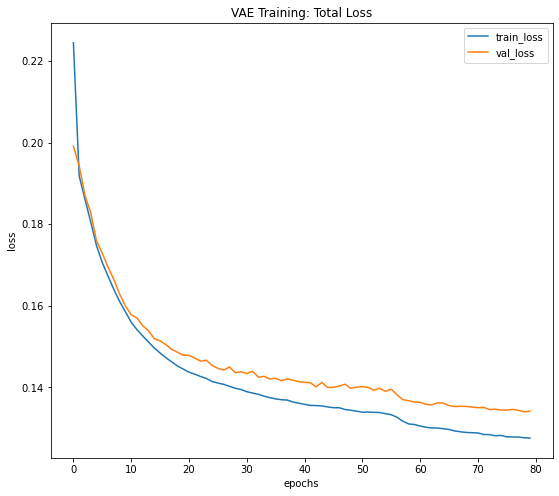

In [50]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Total Loss")
plt.show()

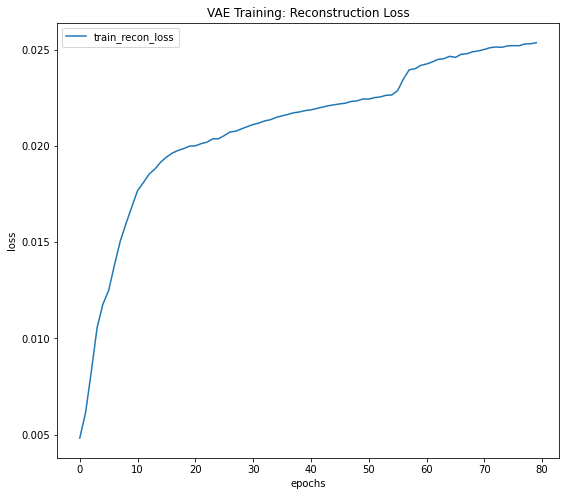

In [51]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

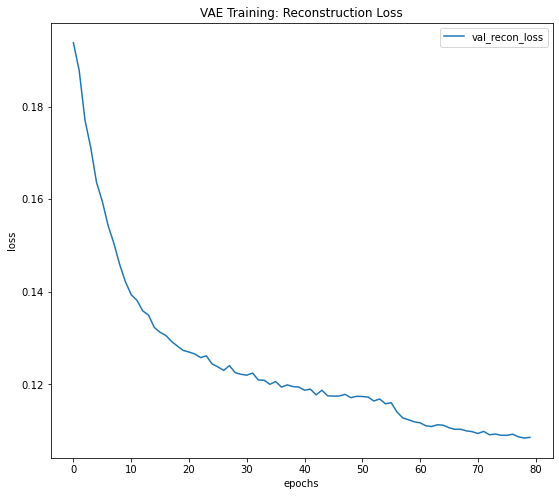

In [52]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

_Reconstruction loss_ has 2 plots since training and validation losses are on different scales.

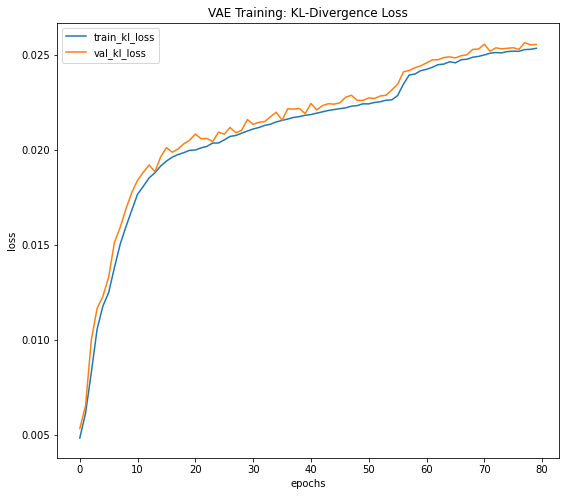

In [53]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: KL-Divergence Loss")
plt.show()

In [84]:
# Save trained VAE model's weights-
# torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load('VAE_LeNet300_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [54]:
import pickle

# Save training history as pickle file-
with open("VAE_LeNet300_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet300_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

### Reconstruct/Generate images using _trained_ VAE model

In [66]:
def synthesize_mnist_images(model, num_samples = 256, latent_dim = 3):
    # Create new MNIST samples using trained model.
    
    # Sample from a multivariate, standard normal distribution-
    z = torch.randn(num_samples, latent_dim).to(device)

    reconstructions = torch.sigmoid(model.decoder(z)).cpu().detach().numpy()
    reconstructions = reconstructions.reshape(-1, 1, 28, 28)
    reconstructions = np.transpose(reconstructions, (0, 2, 3, 1))
    
    return reconstructions


In [67]:
reconstructions = synthesize_mnist_images(
    model = model, num_samples = 256,
    latent_dim = 3
)

In [68]:
reconstructions.shape

(256, 28, 28, 1)

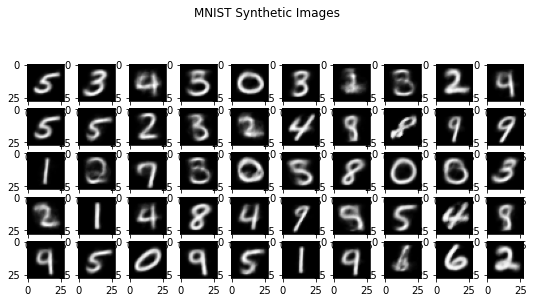

In [70]:
# Visualize 100 synthetic MNIST images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 10 rows and 10 columns-
    plt.subplot(10, 10, i + 1)
    plt.imshow(reconstructions[i], cmap = 'gray')

plt.suptitle("MNIST Synthetic Images")
plt.show()

### Visualize _mean_ and _log-varinace_ in latent-space

In [82]:
mu_l = []
logvar_l = []

In [85]:
for x in train_loader:
    x = x.to(device)
    x_enc = model.encoder(x)
    mu = model.mu(x_enc)
    log_var = model.log_var(x_enc)
    mu_l.append(mu.cpu().detach().numpy())
    logvar_l.append(log_var.cpu().detach().numpy())

In [86]:
len(mu_l), len(logvar_l)

(235, 235)

In [87]:
mu_l = np.vstack(mu_l)
logvar_l = np.vstack(logvar_l)

In [89]:
# Sanity check-
mu_l.shape, logvar_l.shape

((60000, 3), (60000, 3))

In [90]:
del x

In [ ]:
# Visualize latent space for 'mu' vector-
fig = px.scatter_3d(
    x = mu_l[:, 0], y = mu_l[:, 1],
    z = mu_l[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance' vector-
fig = px.scatter_3d(
    x = logvar_l[:, 0], y = logvar_l[:, 1],
    z = logvar_l[:, 2],
    # color = y_train
    )
fig.show()

In [98]:
print(f"Mean vector (mu): mean = {mu_l.mean():4f} & std dev = {mu_l.std():.4f}")

Mean vector (mu): mean = 0.009633 & std dev = 0.9713


In [99]:
print(f"log-variance (log-var): mean = {logvar_l.mean():.4f} & std dev = {logvar_l.std():.4f}")

log-variance (log-var): mean = -4.3080 & std dev = 1.7222


In [100]:
np.sum(mu_l, axis = 0)

array([-1450.2408,  3982.6306,  -798.3585], dtype=float32)

In [101]:
np.sum(logvar_l, axis = 0)

array([-120267.12, -314710.28, -340454.56], dtype=float32)

In [102]:
print("mean vector statistics:")
for i in range(3):
    print(f"lv = {i + 1}: mean = {mu_l[:, i].mean():.4f} & std dev ="
          f" {mu_l[:, i].std():.4f}"
         )

mean vector statistics:
lv = 1: mean = -0.0242 & std dev = 0.9115
lv = 2: mean = 0.0664 & std dev = 0.9576
lv = 3: mean = -0.0133 & std dev = 1.0380


In [103]:
print("log-variance vector statistics:")
for i in range(3):
    print(f"lv = {i + 1}: mean = {logvar_l[:, i].mean():.4f} & std dev ="
          f" {logvar_l[:, i].std():.4f}"
         )

log-variance vector statistics:
lv = 1: mean = -2.0044 & std dev = 0.5936
lv = 2: mean = -5.2452 & std dev = 0.5672
lv = 3: mean = -5.6743 & std dev = 0.4156


__Observation:__ All of the 3 latent variables are learning some useful information in the latent space.

#### Manually synthetize MNIST images by creating latent points

In [129]:
random_point = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [0.1, 0.5, -0.9],
        [-0.9, 0.2, 1.2],
        [2.5, 1.0, -2.5],
        [-0.3, 0.3, -0.3]
    ]
).to(device)

In [130]:
random_point.shape

torch.Size([5, 3])

In [135]:
# Get synthetic image-
recon_manual_points = torch.sigmoid(model.decoder(random_point)).cpu().detach().numpy()

In [137]:
recon_manual_points = recon_manual_points.reshape(-1, 1, 28, 28)
recon_manual_points = np.transpose(recon_manual_points, (0, 2, 3, 1))

In [139]:
recon_manual_points.shape

(5, 28, 28, 1)

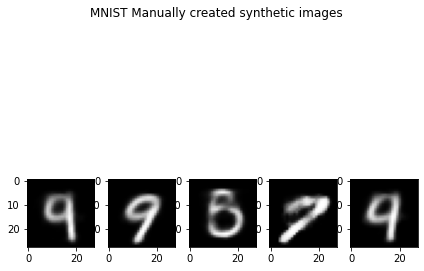

In [142]:
# Visualize 5 manually created synthetic MNIST images-
plt.figure(figsize = (7, 6))
for i in range(5):
    # 1 row and 5 columns-
    plt.subplot(1, 5, i + 1)
    plt.imshow(recon_manual_points[i], cmap = 'gray')

plt.suptitle("MNIST Manually created synthetic images")
plt.show()

In [ ]:
# Save _encoded_ representation for training data-
'''
with open('MNIST_LeNet300_z.npy', 'wb') as file:
    np.save(file, z)
'''

In [ ]:
"""
with open('MNIST_LeNet300_z.npy', 'rb') as file:
    z_encoded = np.load(file)
"""